# DEMO de AutoGLUON sobre series de demanda

Basado en https://auto.gluon.ai/stable/tutorials/timeseries/index.html   
Zoo de modelos: https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-model-zoo.html

In [1]:

# En esta celda se definen los modulos que se van a usar en el notebook 

import numpy as np  # paquete matemático para el manejo de arreglos/arrays
import pandas as pd # paquete de manejo de datos en dataframes o series
import matplotlib.pyplot as plt # paquete para realizar gráficos
import glob
import os


from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


# FORMAS DE VER LAS GRAFICAS --------------------
# ELEGIR UNA DE LAS OPCIONES Y DES-COMENTAR (sacar # de la linea)
# ----------------
# a) graficas en línea  entre las celdas (no interactivo)
%matplotlib inline
# ---------------- 
# b) graficas en línea  entre las celdas (interactivo)
# %matplotlib notebook
# ----------------
# c) graficas en ventanas externas (abre una ventana por cada figura)
# %matplotlib
# ----------------
# d) Si se usa "jupyter lab" en lugar de "jupyter notebook" usar %matplotlib widget en lugar de %matplotlib notebook 
#    Si se usa vscode usar también %matplotlib widget en lugar de %matplotlib notebook 
# requiere instalar el modulo "ipympl". Ver https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab#56416229
# %matplotlib widget
#---------------------------------------------------

### Funciones auxiliares

In [2]:
def cargar_datos_demanda(csv_filename):
    '''
    Los datos vienen como: objeto, fecha, hora, potencia
    '''
    df = pd.read_csv(csv_filename,
                 header=None,
                 names=['objeto', 'fecha', 'hora', 'potencia'],
                 dayfirst=True,
                 dtype={
                        'objeto': 'string',
                        'fecha': 'string',
                        'hora': 'string',
                        'potencia': 'float64'},
                                    
                 )
    # rellenar con ceros la hora que es un texto pero se guardó como número
    df.hora = df.hora.apply(lambda x: '{0:0>4}'.format(x))
    # crear la columna fecha_hora a partir de fecha y hora
    df['fecha_hora'] = pd.to_datetime(df['fecha'] + ' ' + df['hora'], format = '%d/%m/%Y %H%M') 
    # descartar columnas originales de fecha y hora
    df = df.drop(['fecha', 'hora'], axis=1)
    
    return df



## 1. Cargar datos

Cargar datos de 2019

In [3]:
basedir = '../datos/'
basedir = '/home/agomez/Data/AA-UTE-2024/datos_pendrive_map/'

year = 2019
month = '*'
filenames = sorted(glob.glob(os.path.join(basedir, f'Datos_{year}_{month}.txt')))

filenames

['/home/agomez/Data/AA-UTE-2024/datos_pendrive_map/Datos_2019_1.txt',
 '/home/agomez/Data/AA-UTE-2024/datos_pendrive_map/Datos_2019_10.txt',
 '/home/agomez/Data/AA-UTE-2024/datos_pendrive_map/Datos_2019_11.txt',
 '/home/agomez/Data/AA-UTE-2024/datos_pendrive_map/Datos_2019_12.txt',
 '/home/agomez/Data/AA-UTE-2024/datos_pendrive_map/Datos_2019_2.txt',
 '/home/agomez/Data/AA-UTE-2024/datos_pendrive_map/Datos_2019_3.txt',
 '/home/agomez/Data/AA-UTE-2024/datos_pendrive_map/Datos_2019_4.txt',
 '/home/agomez/Data/AA-UTE-2024/datos_pendrive_map/Datos_2019_5.txt',
 '/home/agomez/Data/AA-UTE-2024/datos_pendrive_map/Datos_2019_6.txt',
 '/home/agomez/Data/AA-UTE-2024/datos_pendrive_map/Datos_2019_7.txt',
 '/home/agomez/Data/AA-UTE-2024/datos_pendrive_map/Datos_2019_8.txt',
 '/home/agomez/Data/AA-UTE-2024/datos_pendrive_map/Datos_2019_9.txt']

In [27]:
df = pd.concat([cargar_datos_demanda(f) for f in filenames], axis=0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 9835102 entries, 0 to 809279
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   objeto      string        
 1   potencia    float64       
 2   fecha_hora  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), string(1)
memory usage: 300.1 MB


objeto  potencia fecha_hora
0  APA5DTR1EAE    0.0000 2019-01-01
1  APA5DTR1EAS    0.3276 2019-01-01
2  BACODTR1EAE    0.0000 2019-01-01
3  BACODTR1EAS    0.5725 2019-01-01
4  BACOROSEEAE    0.0000 2019-01-01

In [28]:

df_train = df.loc[df.fecha_hora<pd.to_datetime('2019-06-01')]
df_test = df.loc[df.fecha_hora<pd.to_datetime('2019-07-01')]


In [29]:

train_data = TimeSeriesDataFrame.from_data_frame(
    df_train,
    id_column="objeto",
    timestamp_column="fecha_hora"
)
display(train_data.head())
display(train_data.tail())


potencia
item_id     timestamp           
APA5DTR1EAE 2019-01-01    0.0000
APA5DTR1EAS 2019-01-01    0.3276
BACODTR1EAE 2019-01-01    0.0000
BACODTR1EAS 2019-01-01    0.5725
BACOROSEEAE 2019-01-01    0.0000

potencia
item_id     timestamp                    
CMINRRA1EAS 2019-05-31 23:45:00    2.5700
CMINRRA2EAS 2019-05-31 23:45:00    2.5890
DRIADG01EAS 2019-05-31 23:45:00    0.0000
OCRLBTR1EAE 2019-05-31 23:45:00    0.0000
OCRLBTR1EAS 2019-05-31 23:45:00    0.0675

In [30]:
test_data = TimeSeriesDataFrame.from_data_frame(
    df_test,
    id_column="objeto",
    timestamp_column="fecha_hora"
)
display(test_data.head())
display(test_data.tail())


potencia
item_id     timestamp           
APA5DTR1EAE 2019-01-01    0.0000
APA5DTR1EAS 2019-01-01    0.3276
BACODTR1EAE 2019-01-01    0.0000
BACODTR1EAS 2019-01-01    0.5725
BACOROSEEAE 2019-01-01    0.0000

potencia
item_id     timestamp                    
CMINRRA1EAS 2019-06-30 23:45:00    1.9490
CMINRRA2EAS 2019-06-30 23:45:00    1.9660
DRIADG01EAS 2019-06-30 23:45:00    0.0000
OCRLBTR1EAE 2019-06-30 23:45:00    0.0000
OCRLBTR1EAS 2019-06-30 23:45:00    0.0575

## 2. Usar el TimeSeriesPredictor que prueba múltiples predictores

Los datos son 15-minutales  
Se van a predecir los siguientes 15 días (1440 intervalos = 4 intervalos de 15min * 24h * 15 dias )

El time_limit determina la cantidad de segundos destinada a evaluar modelos. 

In [9]:
predictor = TimeSeriesPredictor(
    prediction_length=1440,  # 15 días (1440 intervalos = 4 intervalos de 15min * 24h * 15 dias)
    path="autogluon-demanda-15min",  # donde se va a guardar los logs  y modelos evaluados 
    target="potencia",    
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="medium_quality",  #determina los modelos que se van a evaluar 
    time_limit=600,  # limita el tiempo de entrenamiento y prueba de modelos
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'autogluon-demanda-15min'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #29~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Apr  4 14:39:20 UTC 2
CPU Count:          8
GPU Count:          0
Memory Avail:       18.44 GB / 38.89 GB (47.4%)
Disk Space Avail:   118.78 GB / 737.35 GB (16.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1440,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'potencia',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: '15T'
Provided train_data

### Realizar predicciones con el mejor modelo

Se predicen los 1440 intervalos (15 días) luego de los datos de entrenamiento  

Ver que los datos de entrenamiento iban hasta mayo 2019 y las predicciones son de los primeros días de junio 2019 

In [12]:
predictions = predictor.predict(train_data)
predictions.head()


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean       0.1       0.2       0.3       0.4   
item_id     timestamp                                                           
APA5DTR1EAE 2019-06-01 00:00:00   0.0 -0.001228 -0.000807 -0.000503 -0.000243  \
            2019-06-01 00:15:00   0.0 -0.001289 -0.000847 -0.000527 -0.000255   
            2019-06-01 00:30:00   0.0 -0.001336 -0.000877 -0.000546 -0.000264   
            2019-06-01 00:45:00   0.0 -0.001375 -0.000903 -0.000563 -0.000272   
            2019-06-01 01:00:00   0.0 -0.001409 -0.000925 -0.000577 -0.000279   

                                 0.5       0.6       0.7       0.8       0.9  
item_id     timestamp                                                         
APA5DTR1EAE 2019-06-01 00:00:00  0.0  0.000243  0.000503  0.000807  0.001228  
            2019-06-01 00:15:00  0.0  0.000255  0.000527  0.000847  0.001289  
            2019-06-01 00:30:00  0.0  0.000264  0.000546  0.000877  0.001336  
            2019-06-01 00:45:00  0.0  0.000272  0.000563  0.000903  0.001375  
            2019-06-01 01:00:00  0.0  0.000279  0.000577  0.000925  0.001409

### Graficar las predicciones

Trafos de Durazno y Artigas

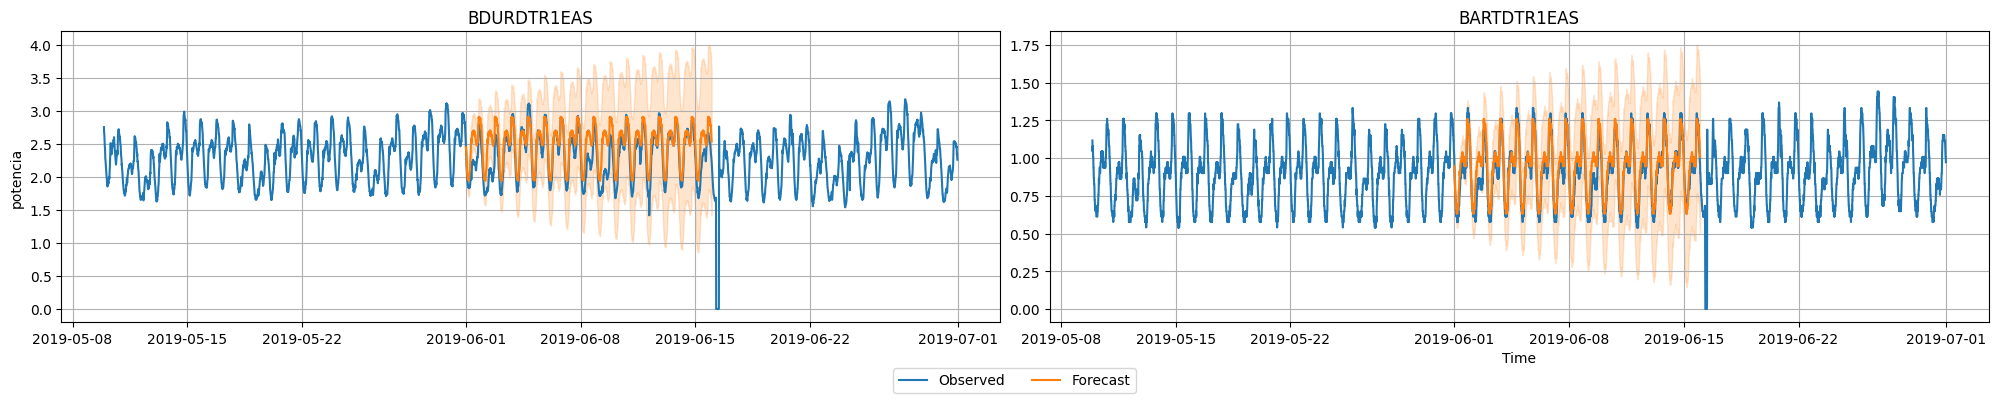

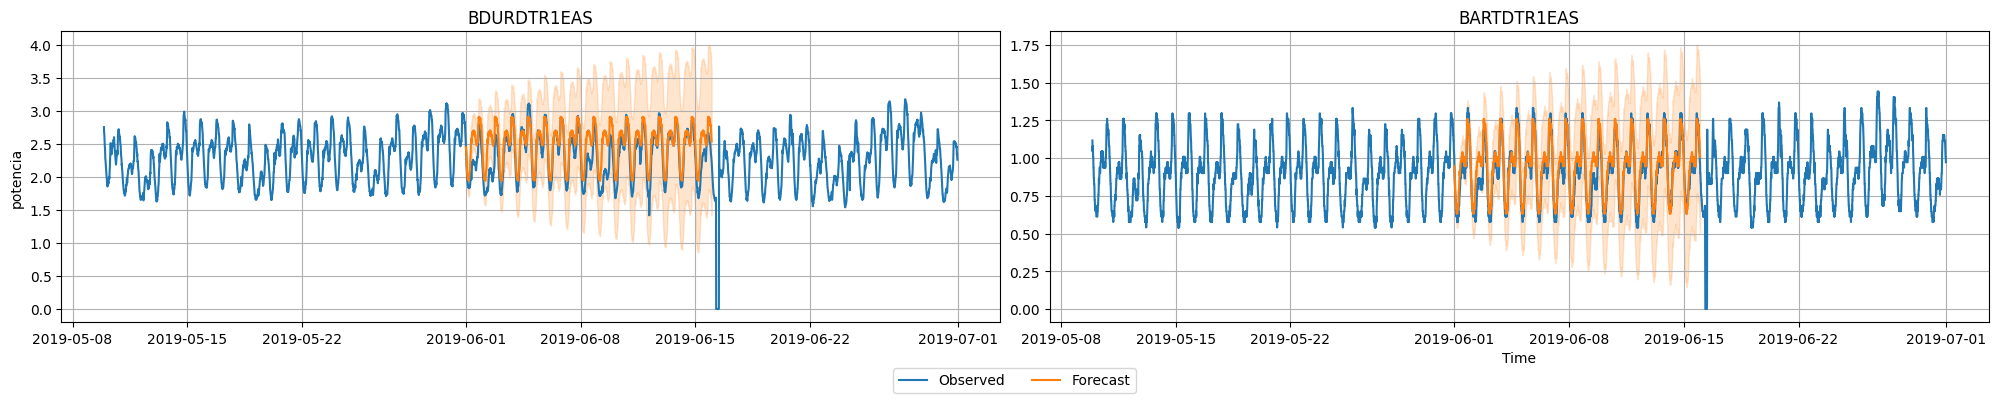

In [14]:
# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], 
               max_history_length=5000, max_num_item_ids=4,
               item_ids=['BDURDTR1EAS', 'BARTDTR1EAS'])

### Leaderboard de los modelos evaluados

In [16]:
leaderboard = predictor.leaderboard(test_data)
leaderboard

model   score_test    score_val  pred_time_test  pred_time_val   
0  WeightedEnsemble    -5.851251    -1.297389        2.203647       2.851679  \
1     SeasonalNaive    -5.856748    -1.315411        0.908199       0.893642   
2             Naive    -6.318516    -1.866896        1.196462       1.958036   
3             Theta    -7.297091    -3.089474       29.931154      28.617978   
4               ETS   -44.377992   -54.414212       22.711642      25.418150   
5     DirectTabular  -655.900663  -546.522424       18.544826      17.630248   
6  RecursiveTabular -1434.693439 -1221.651536      172.406426     178.585447   

   fit_time_marginal  fit_order  
0          47.444633          7  
1           3.526597          2  
2           3.456799          1  
3           3.253967          6  
4           3.307052          5  
5          83.676277          4  
6         170.444562          3